## import

In [1]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier

sc = StandardScaler()
import pickle

## caricamento dati

### caricamento labels pazienti

In [ ]:
#file_path = "/kaggle/input/data-rad/data_rad_clin_DEF.csv"
file_path="../CSV/data_rad_clin_DEF.csv"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\data_rad_clin_DEF.csv"
data = pd.read_csv(file_path)

labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)
print("Labels:", labels)
print("Number of labels:", len(labels))


### caricamento features autoencoder

In [ ]:
file_path="/Users/alessiamenozzi/Desktop//tabella_risultati_resnet50.csv"
df = pd.read_csv(file_path, sep=',')
df = df.astype(float)


df_features = df.drop(columns=['paziente'])

features = df_features.to_numpy()

print(features)
print(features.shape)  


### caricamento features radiomica

In [22]:

file_path="/Users/alessiamenozzi/Desktop//tabella_risultati_resnet50.csv"
df = pd.read_csv(file_path, sep=';')
df = df.astype(float)

# Colonne da rimuovere SOLO PER RADIOMICA
columns_to_remove = [
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df.drop(columns=columns_to_remove)
df_features = df_cleaned.drop(columns=['Paziente'])

features = df_features.to_numpy()

print(features)
print(features.shape)  


Labels: [0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 1 0 1]
Number of labels: 124
[[3.9401479  6.587558   0.3925891  ... 0.         0.13909316 2.5119796 ]
 [2.1214728  0.58344626 0.         ... 0.         0.         0.34409094]
 [3.5523205  2.705209   0.         ... 0.         4.9674006  0.3434775 ]
 ...
 [3.1836472  2.7583075  0.         ... 0.         0.         0.        ]
 [2.0079982  4.8374524  0.05322218 ... 0.61337423 0.57078445 0.8720467 ]
 [1.3667797  3.669598   0.         ... 0.11900234 0.         5.721055  ]]
(124, 2048)


## funzioni

In [23]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected



## FUNZIONE DI CLASSIFICAZIONE
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    
  

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_pred_custom_test)

            precision, recall, _ = precision_recall_curve(y_test, y_pred_custom_test)
            pr_auc = auc(recall, precision)

            best_precision = precision[np.argmax(recall)]
            best_recall = recall[np.argmax(recall)]

            conf = confusion_matrix(y_test, y_pred_custom_test)

            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold
                }

    return best_case



## split

In [24]:
#y_train1, y_test, x_train1, X_test= train_test_split(Y_train, x_train, test_size=0.2, shuffle=False, random_state=1)
#y_train, y_val, X_train, X_val= train_test_split(y_train1, x_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=2)
#y_train, y_val, X_train, X_val= train_test_split(y_train1, x_train1, test_size=0.3, shuffle=False, random_state=7)

Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.2, shuffle=False, random_state=1)

## correlation e p_value

In [25]:

## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.9)
#X_val_reduced = np.delete(X_val, dropped_features, axis=1)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)

print(X_train_reduced.shape)
print(X_test_reduced.shape)
#print(X_val_reduced.shape)

# RIMOZIONE FEATURES CON P_VALUE ELEVATO

X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=0.05)
#X_val_reduced = X_val_reduced[:, features_to_keep]
X_test_reduced = X_test_reduced[:, features_to_keep]


print(X_train_reduced.shape)
print(X_test_reduced.shape)
#print(X_val_reduced.shape)

(99, 2019)
(25, 2019)
(99, 86)
(25, 86)


## parametri

In [26]:
alpha_values = np.linspace(0, 0.006, 30).tolist()

thresholds=np.arange(0.001, 0.501, 0.001) 

selectors=['p_value', 'mrmr','rf', 'logistic', 'lasso']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']


## loop cross val

In [ ]:
n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

scores = []
template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'best_threshold': None,
                'selected_features': []
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(9000000)]
results_val.append(template_dict.copy())


k=0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            print("Starting with selector:", selector)

            best_f1 = 0
            best_case = None

            if(selector=='lasso'):
                for alpha in alpha_values:

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                    
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                best_case = classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, num_features=0, mode="Val", selected_features=[0])

                if best_case:
                    results_val[k]['fold']=fold_idx
                    results_val[k]['classifier']=classifier
                    results_val[k]['selector']=selector
                    results_val[k]['alpha']=best_case['alpha']
                    results_val[k]['selected_features']=best_case['selected_features']
                    results_val[k]['pr_auc']=best_case['pr_auc']
                    results_val[k]['best_precision']=best_case['best_precision']
                    results_val[k]['best_recall']=best_case['best_recall']
                    results_val[k]['roc_auc']=best_case['roc_auc']
                    results_val[k]['f1']=best_case['f1']
                    results_val[k]['accuracy']=best_case['accuracy']
                    results_val[k]['confusion_matrix']=best_case['confusion_matrix']
                    results_val[k]['best_threshold']=best_case['best_threshold']

                    k=k+1
            
            else: 
                limit=len(x_train_reduced[0]) + 1
                for t in range(2, limit):
                    #print("Number of features ", t)

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                        
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    best_case = classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])


                    if best_case:
                        results_val[k]['num_features']=best_case['num_features']
                        results_val[k]['fold']=fold_idx
                        results_val[k]['classifier']=classifier
                        results_val[k]['selector']=selector
                        results_val[k]['selected_features']=best_case['selected_features']
                        results_val[k]['pr_auc']=best_case['pr_auc']
                        results_val[k]['best_precision']=best_case['best_precision']
                        results_val[k]['best_recall']=best_case['best_recall']
                        results_val[k]['roc_auc']=best_case['roc_auc']
                        results_val[k]['f1']=best_case['f1']
                        results_val[k]['accuracy']=best_case['accuracy']
                        results_val[k]['confusion_matrix']=best_case['confusion_matrix']
                        results_val[k]['best_threshold']=best_case['best_threshold']
                        k=k+1




## salvataggio results_val

In [25]:
# Salva il dizionario in un file pickle
with open('/Users/alessiamenozzi/Desktop/results_val5foldResnet50.pkl', 'wb') as pickle_file:
    pickle.dump(results_val, pickle_file)

In [9]:
# Carica il dizionario dal file pickle

with open('/Users/alessiamenozzi/Desktop/results_val10foldResnet86.pkl', 'rb') as pickle_file:
    results_val = pickle.load(pickle_file)

# Ora 'results_val' contiene i dati che hai salvato
print("Dati caricati correttamente:", type(results_val))

Dati caricati correttamente: <class 'list'>


## trova configurazione migliore con gridsearch
fa una lista di tutte le combinazioni di configurazioni dalla migliore (considerando average f1)

In [ ]:
import statistics

# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value', 'lasso']
num_features_range = list(range(2, len(X_train_reduced[0]) + 1))


grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features)
for classifier in classifiers:
    print(f"sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"sto iniziando selector {selector}")

        if (selector)=='lasso':
            for alpha in alpha_values:
                filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha]

                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]
                    
                    # Calcola le medie delle metriche
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                    
                    # Calcola la deviazione standard delle metriche
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                    
                    # Memorizza i risultati medi e la deviazione standard di questa combinazione
                    grid_results[(classifier, selector, alpha)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy
                    }
        
        else:
            for num_features in num_features_range:
                # Filtra i risultati che corrispondono a questa combinazione di parametri
                filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features]
                
                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]
                    
                    # Calcola le medie delle metriche
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                    
                    # Calcola la deviazione standard delle metriche
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                    
                    # Memorizza i risultati medi e la deviazione standard di questa combinazione
                    grid_results[(classifier, selector, num_features)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy
                    }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']), reverse=True)



## Stampa n risultati migliori per validation + performance su test

In [ ]:
n=5
best_3_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni


print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features: {params[2]}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))


    print("Metrics from best_case ON THE TEST SET:")
    if (params[1]=='lasso'):
            print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
    print(f"Best Threshold: {best_case['best_threshold']}")

## codice che prende solo le configurazioni migliori per il test con una soglia di f1

In [20]:
threshold_f1 = 0.6  # soglia minima dell'F1 Score
best_combination_found = False  # Flag per indicare se è stata trovata una buona combinazione
i = 0

while not best_combination_found and i < len(sorted_results):
    params, metrics = sorted_results[i]

    if params[0] == 'RandomForest':
        classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
        classi = LogisticRegression()
    elif params[0] == 'SVM':
        classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
        classi = XGBClassifier()
    elif params[0] == 'MLP':
        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        logistic_model = LogisticRegression(random_state=42)
        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
        classi = VotingClassifier(
            estimators=[
                ('random_forest', rf_model),
                ('logistic', logistic_model),
                ('svc', svc_model)
            ],
            voting='soft'
        )

    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))


    # Controlla se l'F1 Score supera la soglia
    if best_case['f1'] >= threshold_f1:
        print(f"\n#Analizzando combinazione {i + 1}:")
        print(f"Classifier: {params[0]}")
        print(f"Selector: {params[1]}")
        if(selector=='lasso'):
            print(f"Alpha: {params[2]}")
        else: 
            print(f"Num_features: {params[2]}")

        print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")
        #print(f"\nTrovata una combinazione con F1 Score >= {threshold_f1}")
        
        best_combination_found = True
        print("Metrics from best_case ON THE TEST SET:")
        if(selector=='lasso'):
            print(f"Alpha: {best_case['alpha']}")
        print(f"Number of Features: {best_case['num_features']}")
        print(f"Selected Features: {best_case['selected_features']}")
        print(f"Precision-Recall AUC: {best_case['pr_auc']}")
        print(f"Best Precision: {best_case['best_precision']}")
        print(f"Best Recall: {best_case['best_recall']}")
        print(f"ROC AUC: {best_case['roc_auc']}")
        print(f"F1 Score: {best_case['f1']}")
        print(f"Accuracy: {best_case['accuracy']}")
        print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
        print(f"Best Threshold: {best_case['best_threshold']}")
        i += 1
    else:
        i += 1  # Passa alla prossima combinazione

if not best_combination_found:
    print(f"\nNessuna combinazione con F1 Score >= {threshold_f1} è stata trovata.")



#Analizzando combinazione 1:
Classifier: RandomForest
Selector: lasso
Num_features: 0.006
Performance medie: F1 = 0.8662193362193362 (std = 0.11517904682719592), PR AUC = 0.8757132936507939 (std = 0.10989373911384227), Accuracy = 0.8472222222222221 (std = 0.13764878469739358)

Trovata una combinazione con F1 Score >= 0.68!
Metrics from best_case ON THE TEST SET:
Alpha: 0
Number of Features: 75
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74]
Precision-Recall AUC: 0.4112088279367691
Best Precision: 0.3157894736842105
Best Recall: 1.0
ROC AUC: 0.655448717948718
F1 Score: 0.6
Accuracy: 0.6842105263157895
Confusion Matrix: 
[[17  9]
 [ 3  9]]
Best Threshold: 0.5000000000000002

Nessuna combinazione con F1 Score >= 0.68 è stata trovata.


## PLOT

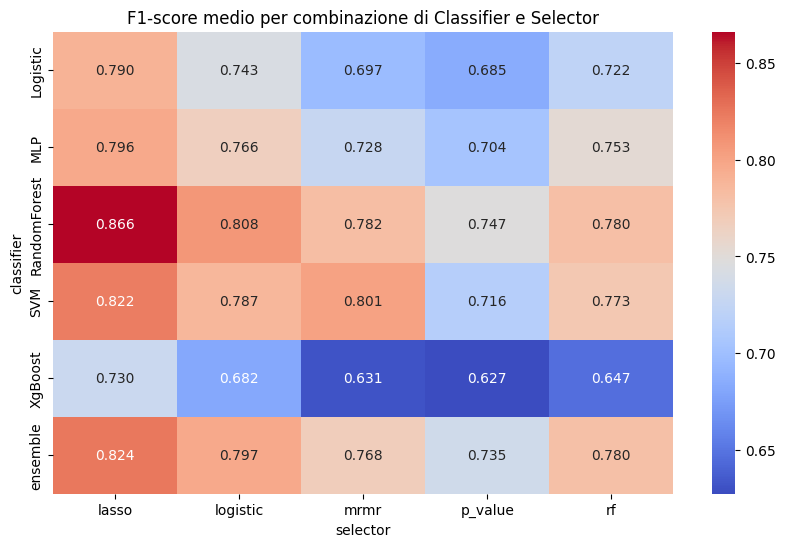

In [19]:

# Crea un pivot per visualizzare i dati nella heatmap
results_df = pd.DataFrame(results_val)
heatmap_data = results_df.pivot_table(index='classifier', columns='selector', values='f1', aggfunc='mean')

# Crea la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('F1-score medio per combinazione di Classifier e Selector')
plt.show()

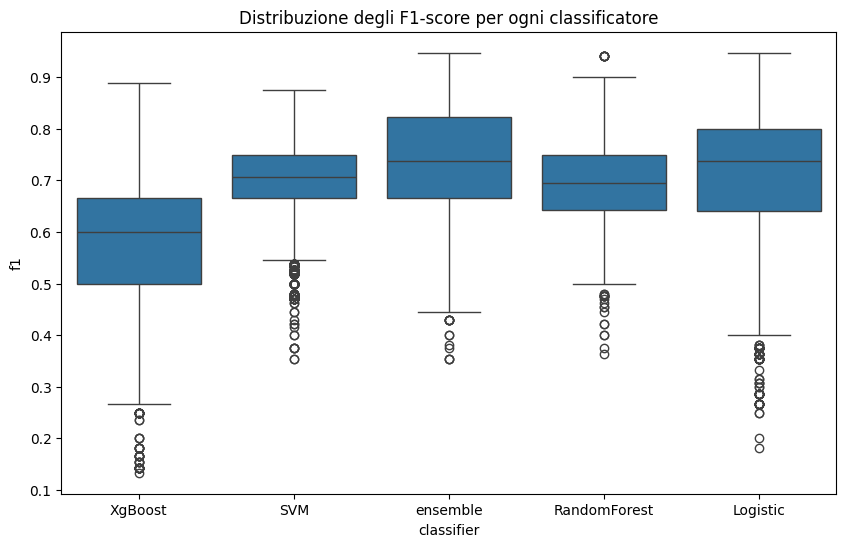

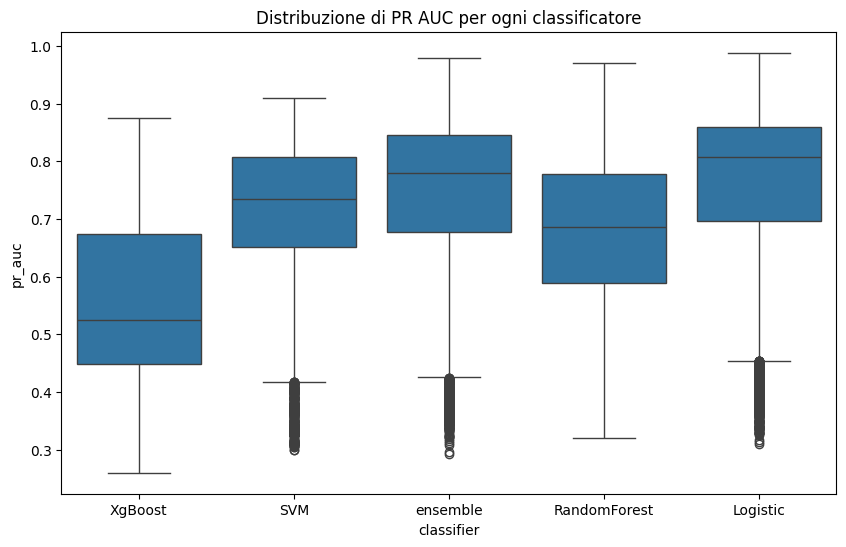

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Converto i risultati in un DataFrame per visualizzare meglio
results_df = pd.DataFrame(results_val)

# Crea un boxplot per l'F1-score
plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='f1', data=results_df)
plt.title('Distribuzione degli F1-score per ogni classificatore')
plt.show()

# Crea un boxplot per PR AUC
plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='pr_auc', data=results_df)
plt.title('Distribuzione di PR AUC per ogni classificatore')
plt.show()
